# DIRECT FEEDBACK ALIGNMENT ON MNIST

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import mnist
# from keras.datasets import cifar10
# from keras.utils.np_utils import to_categorical
from tensorflow.python.keras.utils.np_utils import to_categorical
np.random.seed(1234) # fix first random number
%matplotlib inline

## CREATING DATASET

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255 # normalize data
X_test /= 255 # normalize data

11490434/11490434 [==============================] - 0s 0us/step


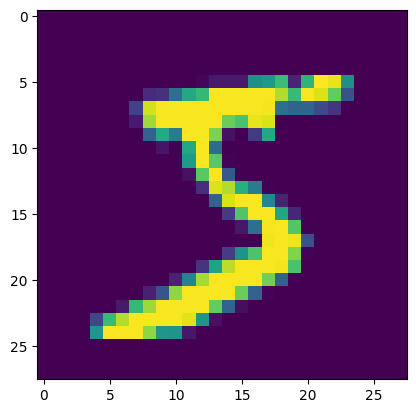

In [ ]:
plt.imshow(X_train[0])

In [ ]:
print('Input dimensions')
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

X_train = X_train.reshape(60000, 28*28)
X_test = X_test.reshape(10000, 28*28)

print('After reshaping:', X_train.shape, X_test.shape)

Input dimensions
(60000, 28, 28) (10000, 28, 28)
(60000,) (10000,)
After reshaping: (60000, 784) (10000, 784)


In [ ]:
print('Sample of label:', y_train[0])

Sample of label: 5


In [ ]:
nb_classes = 10
y_train = to_categorical(y_train, nb_classes)
y_test = to_categorical(y_test, nb_classes)

In [ ]:
print('After conversion to categorical:', y_train[0])

After conversion to categorical: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


## DEFINITION OF FORWARD AND BACKWARD PASS

In [ ]:
# import of sigmoid and crossentropy
from scipy.special import expit
from sklearn.metrics import log_loss

In [ ]:
def forward_pass2(W1,W2,W3,b1,b2,b3,x):
    # if the input is a batch, I have to tile as many
    # b1 and b2 as the batch size
    a1 = np.matmul(W1, x)+np.tile(b1, x.shape[1])
    h1 = np.tanh(a1)

    a2 = np.matmul(W2, h1)+np.tile(b2, x.shape[1])
    h2 = np.tanh(a2)

    a3 = np.matmul(W3, h2)+np.tile(b3, x.shape[1])
    y_hat = expit(a3)
    return a1, h1, a2, h2, a3, y_hat

In [ ]:
def backprop_backward_pass2(e, h1, h2, W2, W3, a1, a2, x):
    dW3 = -np.matmul(e,np.transpose(h2))
    db3 = -np.sum(e, axis=1)

    da2 = np.matmul(np.transpose(W3), e)*(1-np.tanh(a2)**2)
    dW2 = -np.matmul(da2, np.transpose(h1))
    db2 = -np.sum(da2,axis=1)

    da1 = np.matmul(np.transpose(W2), da2)*(1-np.tanh(a1)**2)
    dW1 = -np.matmul(da1, np.transpose(x))
    db1 = -np.sum(da1, axis=1)

    return dW1, dW2, dW3, db1[:,np.newaxis], db2[:,np.newaxis], db3[:,np.newaxis]

## DEFINITION OF FUNCTION TO COMPUTE ANGLE BETWEEN UPDATES

In [ ]:
def average_angle(W2, B1, error, a1, a2):
    dh1 = np.mean(np.matmul(B1, error), axis=1)[:, np.newaxis] #forse non ci va la derivata
    c1 = np.mean(np.matmul(np.transpose(W2), error*(expit(a2)*(1-expit(a2)))), axis=1)[:, np.newaxis]
    dh1_norm = np.linalg.norm(dh1)
    c1_norm = np.linalg.norm(c1)
    inverse_dh1_norm = np.power(dh1_norm, -1)
    inverse_c1_norm = np.power(c1_norm, -1)

    # ALIGNMENT CRITERION AND ANGLE
    Lk = (np.matmul(np.transpose(dh1), c1)*inverse_dh1_norm)[0, 0]
    beta = np.arccos(np.clip(Lk*inverse_c1_norm, -1., 1.))*180/np.pi
    return Lk, beta

In [ ]:
def train2(x, y, n_epochs=10, lr=1e-3, batch_size=200, tol=1e-1):
    x = np.transpose(x)
    y = np.transpose(y)

    W1, W2, W3 = np.random.randn(800, 784), np.random.randn(800,800), np.random.randn(10, 800)
    b1, b2, b3 = np.random.randn(800, 1), np.random.randn(800,1), np.random.randn(10, 1)

    dataset_size = x.shape[1]
    n_batches = dataset_size//batch_size
    te_bp = []
    for i in range(n_epochs):
        perm = np.random.permutation(x.shape[1])
        x = x[:, perm]
        y = y[:, perm]
        loss = 0.
        train_error = 0.
        for j in range(n_batches):
            samples = x[:, j*batch_size:(j+1)*batch_size]
            targets = y[:, j*batch_size:(j+1)*batch_size]
            a1, h1, a2, h2, a3, y_hat = forward_pass2(W1, W2, W3, b1, b2, b3, samples)
            error = y_hat - targets
            preds = np.argmax(y_hat, axis=0)
            truth = np.argmax(targets, axis=0)
            train_error += np.sum(preds!=truth)
            loss_on_batch = log_loss(targets, y_hat)

            dW1, dW2, dW3, db1, db2, db3 = backprop_backward_pass2(error, h1, h2, W2, W3, a1, a2, samples)
            W1 += lr*dW1
            W2 += lr*dW2
            W3 += lr*dW3
            b1 += lr*db1
            b2 += lr*db2
            b3 += lr*db3
            loss += loss_on_batch
        training_error = 1.*train_error/x.shape[1]
        print('Loss at epoch', i+1, ':', loss/x.shape[1])
        print('Training error:', training_error)
        prev_training_error = 0 if i==0 else te_bp[-1]
        if np.abs(training_error-prev_training_error) <= tol:
            te_bp.append(training_error)
            break
        te_bp.append(training_error)
    return W1, W2, W3, b1, b2, b3, te_bp

In [ ]:
# print(X_train)
W1, W2, W3, b1, b2, b3, te_bp = train2(X_train, y_train, n_epochs=100, lr=1e-4, batch_size=200, tol=1e-4)

Loss at epoch 1 : 1.4669228822287181
Training error: 0.5546166666666666
Loss at epoch 2 : 0.8544241828407304
Training error: 0.29175
Loss at epoch 3 : 0.7116456429523246
Training error: 0.22096666666666667
Loss at epoch 4 : 0.633661778090426
Training error: 0.1818
Loss at epoch 5 : 0.5785787666196913
Training error: 0.15613333333333335
Loss at epoch 6 : 0.5350319113479536
Training error: 0.13515
Loss at epoch 7 : 0.5022349408188371
Training error: 0.1196
Loss at epoch 8 : 0.4753790223125469
Training error: 0.1057
Loss at epoch 9 : 0.45397029927473004
Training error: 0.0945
Loss at epoch 10 : 0.43632401156062695
Training error: 0.08506666666666667
Loss at epoch 11 : 0.42210362332470813
Training error: 0.07693333333333334
Loss at epoch 12 : 0.40998900433191104
Training error: 0.07051666666666667
Loss at epoch 13 : 0.3997936525107918
Training error: 0.06428333333333333
Loss at epoch 14 : 0.3909490045446205
Training error: 0.059083333333333335
Loss at epoch 15 : 0.38297426896742626
Trainin

In [ ]:
def dfa_backward_pass1(e, h1, B1, a1, x):
    dW2 = -np.matmul(e, np.transpose(h1))
    da1 = np.matmul(B1, e)*(1-np.tanh(a1)**2)
    dW1 = -np.matmul(da1, np.transpose(x))
    db1 = -np.sum(da1, axis=1)
    db2 = -np.sum(e, axis=1)
    return dW1, dW2, db1[:,np.newaxis], db2[:,np.newaxis]

In [ ]:
def dfa_backward_pass2(e, h1, h2, B1, B2, a1, a2, x):
    dW3 = -np.matmul(e,np.transpose(h2))
    db3 = -np.sum(e, axis=1)

    da2 = np.matmul(B2, e)*(1-np.tanh(a2)**2)
    dW2 = -np.matmul(da2, np.transpose(h1))
    db2 = -np.sum(da2,axis=1)

    da1 = np.matmul(B1, e)*(1-np.tanh(a1)**2)
    dW1 = -np.matmul(da1, np.transpose(x))
    db1 = -np.sum(da1, axis=1)

    return dW1, dW2, dW3, db1[:,np.newaxis], db2[:,np.newaxis], db3[:,np.newaxis]

In [ ]:
def dfa_train2(x, y, n_epochs=10, lr=1e-3, batch_size=200, tol=1e-3):
    x = np.transpose(x)
    y = np.transpose(y)

    W1, W2, W3 = np.random.randn(800, 784), np.random.randn(800,800), np.random.randn(10, 800)
    b1, b2, b3 = np.random.randn(800, 1), np.random.randn(800,1), np.random.randn(10, 1)

    B1 = np.random.randn(800,10)
    B2 = np.random.randn(800,10)
    dataset_size = x.shape[1]
    n_batches = dataset_size//batch_size
    te_dfa = []
    angles = []
    for i in range(n_epochs):
        perm = np.random.permutation(x.shape[1])
        x = x[:, perm]
        y = y[:, perm]
        loss = 0.
        train_error = 0.
        for j in range(n_batches):
            samples = x[:, j*batch_size:(j+1)*batch_size]
            targets = y[:, j*batch_size:(j+1)*batch_size]
            a1, h1, a2, h2, a3, y_hat = forward_pass2(W1, W2, W3, b1, b2, b3, samples)
            error = y_hat - targets
            preds = np.argmax(y_hat, axis=0)
            truth = np.argmax(targets, axis=0)
            train_error += np.sum(preds!=truth)
            loss_on_batch = log_loss(targets, y_hat)

            dW1, dW2, dW3, db1, db2, db3 = dfa_backward_pass2(error, h1, h2, B1, B2, a1, a2, samples)
            W1 += lr*dW1
            W2 += lr*dW2
            W3 += lr*dW3
            b1 += lr*db1
            b2 += lr*db2
            b3 += lr*db3
            loss += loss_on_batch
        training_error = 1.*train_error/x.shape[1]
        print('Loss at epoch', i+1, ':', loss/x.shape[1])
        print('Training error:', training_error)
        prev_training_error = 0 if i==0 else te_dfa[-1]
        if np.abs(training_error-prev_training_error) <= tol:
            te_dfa.append(training_error)
            break
        te_dfa.append(training_error)
    return W1, W2, W3, b1, b2, b3, te_dfa, angles

In [ ]:
W1dfa, W2dfa, W3dfa, b1dfa, b2dfa, b3dfa, te_dfa, angles = dfa_train2(X_train, y_train, n_epochs=100, lr=1e-4, batch_size=200, tol=1e-4)

Loss at epoch 1 : 1.9258971791382629
Training error: 0.75995
Loss at epoch 2 : 1.3019250451735236
Training error: 0.5251666666666667
Loss at epoch 3 : 1.0660153625417266
Training error: 0.4145666666666667
Loss at epoch 4 : 0.9414959635535509
Training error: 0.35075
Loss at epoch 5 : 0.8643132001500524
Training error: 0.3072166666666667
Loss at epoch 6 : 0.812931759897734
Training error: 0.2786166666666667
Loss at epoch 7 : 0.7716889979832251
Training error: 0.25635
Loss at epoch 8 : 0.7374340872275379
Training error: 0.23898333333333333
Loss at epoch 9 : 0.7104425593521715
Training error: 0.22375
Loss at epoch 10 : 0.6868590014774669
Training error: 0.21085
Loss at epoch 11 : 0.667390874434253
Training error: 0.19988333333333333
Loss at epoch 12 : 0.6503398422948462
Training error: 0.1913
Loss at epoch 13 : 0.6356344799788995
Training error: 0.18325
Loss at epoch 14 : 0.6213220951490258
Training error: 0.17516666666666666
Loss at epoch 15 : 0.6101089987268808
Training error: 0.16965
Lo

In [ ]:
def test(W1, W2, W3, b1, b2, b3, test_samples, test_targets):
    test_samples = np.transpose(test_samples)
    test_targets = np.transpose(test_targets)
    # outs = forward_pass1(W1, W2, b1, b2, test_samples)[-1]
    outs = forward_pass2(W1, W2, W3, b1, b2, b3, test_samples)[-1]
    preds = np.argmax(outs, axis=0)
    truth = np.argmax(test_targets, axis=0)
    test_error = 1.*np.sum(preds!=truth)/preds.shape[0]
    return test_error

In [ ]:
print('BP test error:', test(W1, W2 ,W3, b1, b2, b3, X_test, y_test)*100, '%')
print('DFA test error:', test(W1dfa, W2dfa, W3dfa, b1dfa, b2dfa, b3dfa, X_test, y_test)*100, '%')

BP test error: 15.129999999999999 %
DFA test error: 9.43 %


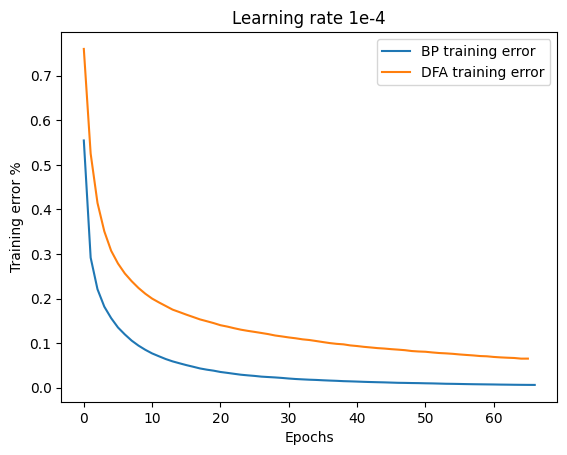

In [ ]:
plt.plot(range(len(te_bp)), te_bp, label='BP training error')
plt.plot(range(len(te_dfa)), te_dfa, label='DFA training error')
plt.title('Learning rate 1e-4')
plt.xlabel('Epochs')
plt.ylabel('Training error %')
plt.legend(loc='best')
plt.savefig("output.jpg")
plt.show()

In [ ]:
l, beta = zip(*angles)

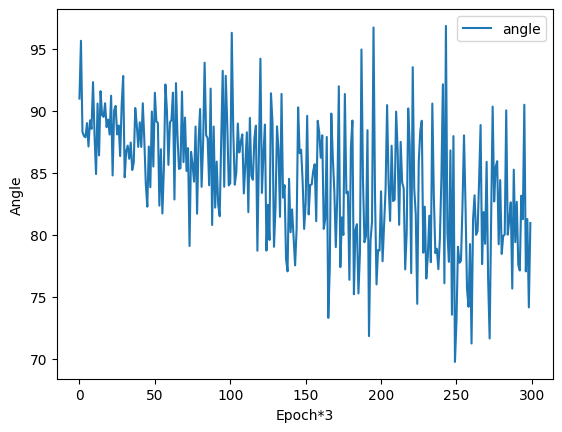

In [ ]:
plt.plot(range(len(beta)), beta, label='angle')
plt.legend(loc='best')
plt.xlabel('Epoch*3')
plt.ylabel('Angle')
plt.show()